Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

Versão: 1.2.090620

In [1]:
%load_ext watermark

In [2]:
from random import randint, random
import datetime
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [3]:
# Run this cell before close.
%watermark
%watermark --iversion
%watermark -b -r -g

2020-06-09T21:00:20+00:00

CPython 3.7.7
IPython 7.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 4.19.76-linuxkit
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit
pandas 1.0.4

Git hash: 4873704b39e1d3c6a7734479b08dbcafeaa6a8bf
Git repo: https://github.com/ysraell/datavis.git
Git branch: master


In [4]:
def decision(probability):
    return random() < probability

def gen_ID(tag,d=6):
    return "{tag}{n:0{d}}".format(d=d,tag=tag,n=randint(0,10**d -1))

In [76]:
class Geradores():
    def __init__(self,ID = None, prob = 0, tag = ''):
        self.qtd = 0
        self.prob = prob
        self.ID = ID if ID is not None else gen_ID('G')
        self.tag = tag
        
    def gera(self):
        self.qtd += decision(self.prob)
        
    def retira(self):
        self.qtd -= 1

class Destruidores():
    def __init__(self,ID = None, prob = 0, tag = ''):
        self.item = False
        self.prob = prob
        self.ID = ID if ID is not None else gen_ID('D')
        self.tag = tag   
        
    def destroi(self):
        self.item = decision(self.prob)
    
class Simulacao():
    def __init__(self,Geradores_Lista,Destruidores_Lista):
        self.Geradores_Lista = Geradores_Lista
        self.Destruidores_Lista = Destruidores_Lista
        self.qtd_G = 0
        self.qtd_D = 0
        self.qtd_g_dia = 0
        self.tags_dia = []

    def ordem_prioridade(self):
        return sorted({Gerador.ID: Gerador.qtd for Gerador in self.Geradores_Lista}.items(), key=lambda x: x[1], reverse=True)
        
    def ID2Gerador(self,ID):
        out = {Gerador.ID: Gerador for Gerador in self.Geradores_Lista}
        return out[ID]

    def atualiza_status(self):
        self.qtd_G = sum([Gerador.qtd for Gerador in self.Geradores_Lista])
        self.qtd_D = sum([Destruidor.item for Destruidor in self.Destruidores_Lista])
    
    def passa_dia(self,util=True):      

        for Gerador in self.Geradores_Lista:
            Gerador.gera()
        ordem = self.ordem_prioridade()
        
        self.qtd_dia = sum([x[1] for x in ordem])-self.qtd_G
        
        self.tags_dia = []
        if util:
            for Destruidor in self.Destruidores_Lista:
                if Destruidor.item:
                    Destruidor.destroi()
                    if not Destruidor.item: 
                        self.tags_dia.append(Destruidor.tag)

                if not Destruidor.item:

                    tmp = [(None,0)]
                    while ordem:
                        tmp = ordem.pop(0)
                        if tmp[1] >0:
                            break

                    if tmp[1] > 0:
                        self.ID2Gerador(tmp[0]).retira()
                        Destruidor.item = True

                if not ordem:
                    ordem = self.ordem_prioridade()
                
        self.atualiza_status()

In [77]:
def gen_prob(a,b):
    return a+(b-a)*random()

def gen_Lista(N, prob_min, prob_max, tag, OBJ):
    return [OBJ(prob= gen_prob(prob_min,prob_max),tag=tag) for _ in range(N)]


In [78]:
gerador_param = (33,0.01,0.05,'cliente')

Renda_dia_gerador = (60, 0.3)
prob_renda = 0.9
Custo_base = 3000/20
Custo_Adicional_level2 = Custo_base+1000/20 
Custo_Adicional_level3 = Custo_Adicional_level2+1500/20 
Custo_para_level2 = 3000 
Custo_para_level3 = 7000
destruidor_param = [(3,0.3,0.4,'1')]
destruidor_param.append((2,0.5,0.6,'2'))
destruidor_param.append((1,0.8,0.9,'3'))

In [79]:
lista_Geradores = gen_Lista(*gerador_param,OBJ=Geradores)
lista_Destruidores_dict = {i+1: gen_Lista(*param,OBJ=Destruidores) for i,param in enumerate(destruidor_param)}
lista_Destruidores = list(itertools.chain(*list(lista_Destruidores_dict.values())))

lista_Geradores = gen_Lista(*gerador_param,OBJ=Geradores)

sistema1 = Simulacao(Geradores_Lista=lista_Geradores,Destruidores_Lista=lista_Destruidores)

numdays = 500
base = datetime.datetime(2017, 6, 1)
def passXdays(x):
    return base + datetime.timedelta(days=x)
date_list = [passXdays(x) for x in range(numdays)]

def sobe_level(level):
    ID = sorted({who.ID: who.prob for who in lista_Destruidores_dict[level]}.items(), key=lambda x: x[1], reverse=True)[0][0]
    for i,who in enumerate(lista_Destruidores_dict[level]):
        if who.ID == ID:
            lista_Destruidores_dict[level+1].append(lista_Destruidores_dict[level][i])
            lista_Destruidores_dict[level].pop(i)
            lista_Destruidores_dict[level+1][-1].prob += level/10
            lista_Destruidores_dict[level+1][-1].tag = str(level+1)
            
def cenario(date):
    
    if date == passXdays(35):
        sobe_level(1)
        return Custo_para_level2

    if date == passXdays(34):
        lista_Geradores.extend(gen_Lista(1,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(40):
        lista_Destruidores_dict[1].pop(0)

    if date == passXdays(44):
        lista_Geradores.extend(gen_Lista(1,0.01,0.1,'cliente',OBJ=Geradores))
                               
    if date == passXdays(50):
        lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores))
        
    if date == passXdays(75):
        sobe_level(2)
        return Custo_para_level3
    
    if date == passXdays(78):
        lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores))        
        
    if date == passXdays(85):
        lista_Destruidores_dict[3].pop(0)
        
    if date == passXdays(105):
        lista_Geradores.extend(gen_Lista(1,0.01,0.1,'cliente',OBJ=Geradores))
         
    if date == passXdays(106):
        sobe_level(1)   
        return Custo_para_level2
    
    if date == passXdays(110):
        lista_Destruidores_dict[2].pop(0)  
        
    if date == passXdays(115):
        lista_Geradores.extend(gen_Lista(4,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(120):
        lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores)) 
    
    if date == passXdays(150):
        lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores)) 
        
    if date == passXdays(160):
        sobe_level(1)
        return Custo_para_level2
    
    if date == passXdays(160):
        lista_Geradores.pop(0)
        lista_Geradores.pop(0)

    
    if date == passXdays(170):
        lista_Destruidores_dict[1].pop(0)
        lista_Destruidores_dict[1].pop(0)
        
    if date == passXdays(174):
        for _ in range(5):
            lista_Geradores.pop(0)

    if date == passXdays(186):
        lista_Destruidores_dict[1].extend(gen_Lista(3,0.3,0.4,'1',OBJ=Destruidores)) 
        
    if date == passXdays(190):
        lista_Geradores.extend(gen_Lista(4,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(210):
        sobe_level(1)
        sobe_level(1)
        return 2*Custo_para_level2

    if date == passXdays(220):
        lista_Destruidores_dict[1].extend(gen_Lista(3,0.3,0.4,'1',OBJ=Destruidores)) 
        
    if date == passXdays(237):
        lista_Destruidores_dict[2].pop(0)
        lista_Destruidores_dict[2].pop(0)
 
    #if date == passXdays(245):
    #    lista_Destruidores_dict[1].extend(gen_Lista(3,0.3,0.4,'1',OBJ=Destruidores)) 

    if date == passXdays(260):
        lista_Geradores.extend(gen_Lista(2,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(264):
        lista_Geradores.extend(gen_Lista(3,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(280):
        lista_Geradores.extend(gen_Lista(7,0.01,0.1,'cliente',OBJ=Geradores))

    if date == passXdays(287):
        lista_Geradores.extend(gen_Lista(10,0.01,0.1,'cliente',OBJ=Geradores))
        
    #if date == passXdays(290):
    #    N = 2
    #    for _ in range(N):
    #        sobe_level(1)
    #    return N*Custo_para_level2

    if date == passXdays(300):
        for _ in range(3):
            lista_Geradores.pop(0)
    
    #if date == passXdays(303):
    #    lista_Destruidores_dict[1].extend(gen_Lista(2,0.3,0.4,'1',OBJ=Destruidores)) 
        
    #if date == passXdays(311):
    #    sobe_level(2)
    #    return Custo_para_level3
    
    #if date == passXdays(314):
    #    sobe_level(1)
    #    return Custo_para_level2
    
    if date == passXdays(344):
        lista_Destruidores_dict[3].pop(0) 
        
    if date == passXdays(300):
        for _ in range(7):
            lista_Geradores.pop(0)
        
    if date == passXdays(354):
        lista_Destruidores_dict[2].pop(0)
        
    if date == passXdays(354):
        lista_Destruidores_dict[1].pop(0)
        
    if date == passXdays(300):
        for _ in range(5):
            lista_Geradores.pop(0)
        
    #if date == passXdays(360):
    #    lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores))
        
    #if date == passXdays(365):
    #    lista_Destruidores_dict[1].extend(gen_Lista(1,0.3,0.4,'1',OBJ=Destruidores))
        
    #if date == passXdays(369):
    #    N = 2
    #    for _ in range(N):
    #        sobe_level(1)
    #    return N*Custo_para_level2
        
    if date == passXdays(378):
        lista_Geradores.extend(gen_Lista(4,0.01,0.1,'cliente',OBJ=Geradores))
        
    if date == passXdays(389):
        lista_Geradores.extend(gen_Lista(9,0.01,0.1,'cliente',OBJ=Geradores))
        

        
    return 0

In [80]:
results = {
    'qtd_D':[],
    'qtd_G':[],
    'qtd_dia':[],
    #'tags_dia':[],
    'n_L1':[],
    'n_L2':[],
    'n_L3':[],
    'n_Geradores':[],
    'custo_dia':[],
    'renda_dia':[],
}
renda_dia = int((1-Renda_dia_gerador[1]*random())*Renda_dia_gerador[0]*len(lista_Geradores))
tmp = []
for date in date_list:
    custo_dia = 0
    custo_dia += cenario(date)
    sistema1.Destruidores_Lista = lista_Destruidores = list(itertools.chain(*list(lista_Destruidores_dict.values())))
    renda_dia = renda_dia if decision(prob_renda) else int((1-Renda_dia_gerador[1]*random())*Renda_dia_gerador[0]*len(lista_Geradores))
    if date.weekday()<=5:
        sistema1.passa_dia(util=(date.weekday()<=4))
        results['qtd_D'].append(sistema1.qtd_D)
        results['qtd_G'].append(sistema1.qtd_G)
        results['qtd_dia'].append(sistema1.qtd_dia)
        tmp.append(sistema1.tags_dia)
        n_L1 = len(lista_Destruidores_dict[1])
        n_L2 = len(lista_Destruidores_dict[2])
        n_L3 = len(lista_Destruidores_dict[3])
        results['n_L1'].append(n_L1)
        results['n_L2'].append(n_L2)
        results['n_L3'].append(n_L3)
        results['n_Geradores'].append(len(lista_Geradores))
        custo_dia += n_L1*Custo_base+ n_L2*Custo_Adicional_level2+  n_L3*Custo_Adicional_level3
        results['custo_dia'].append(custo_dia)
        results['renda_dia'].append(renda_dia)
    else:
        results['qtd_D'].append(sistema1.qtd_D)
        results['qtd_G'].append(sistema1.qtd_G)
        results['qtd_dia'].append(0)
        tmp.append(sistema1.tags_dia)
        n_L1 = len(lista_Destruidores_dict[1])
        n_L2 = len(lista_Destruidores_dict[2])
        n_L3 = len(lista_Destruidores_dict[3])
        results['n_L1'].append(n_L1)
        results['n_L2'].append(n_L2)
        results['n_L3'].append(n_L3)
        results['n_Geradores'].append(len(lista_Geradores))
        results['custo_dia'].append(custo_dia)
        results['renda_dia'].append(int((1-Renda_dia_gerador[1]*random())*Renda_dia_gerador[0]*len(lista_Geradores)))

for i in range(1,4):
    results['des_dia_{}'.format(i)] = [] 
while tmp:
    dia = tmp.pop(0)
    for i in range(1,4):
        results['des_dia_{}'.format(i)].append(sum([1 if int(x) == i else 0 for x in dia]))
df_results = pd.DataFrame.from_dict(results)

In [81]:
df_results['lucro'] = df_results[['renda_dia','custo_dia']].apply(lambda x: x[0]-x[1],axis=1)

In [82]:
n_L1 + n_L2 + n_L3

6

count    500.000000
mean       3.818000
std        2.048724
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max        9.000000
Name: qtd_D, dtype: float64


count    500.000000
mean       4.992000
std       11.427209
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max       56.000000
Name: qtd_G, dtype: float64


count    500.000000
mean       1.752000
std        1.655287
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        8.000000
Name: qtd_dia, dtype: float64


count    500.000000
mean       3.678000
std        1.138819
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: n_L1, dtype: float64


count    500.000000
mean       2.584000
std        0.753711
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: n_L2, dtype: float64


count    500.000000
mean       0.708000
std       

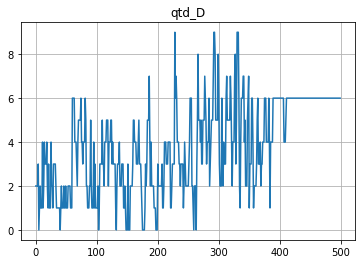

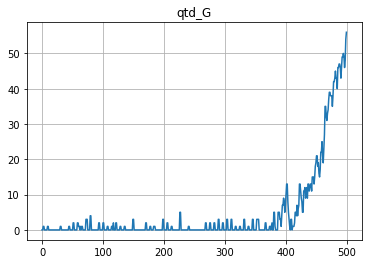

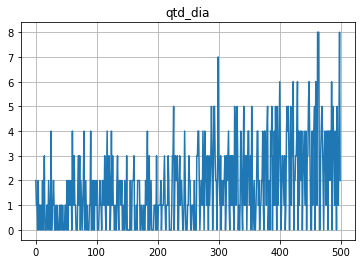

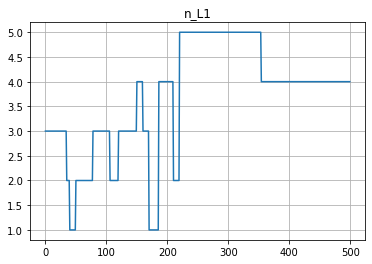

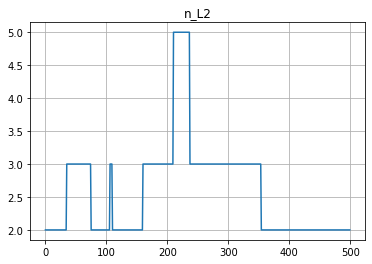

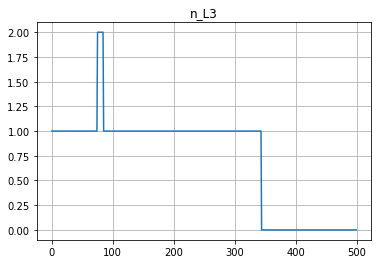

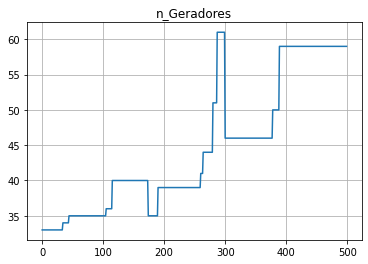

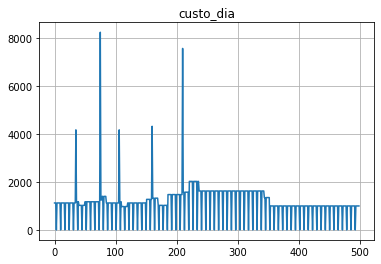

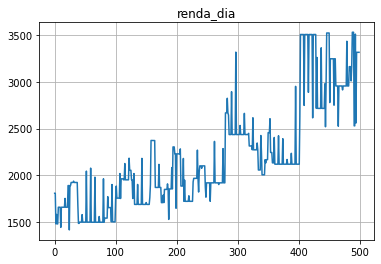

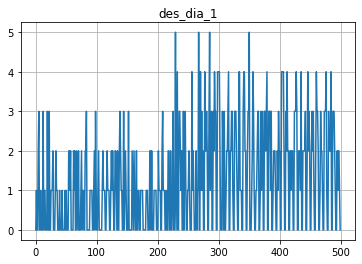

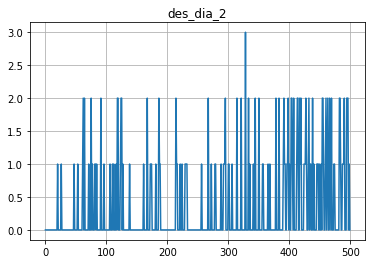

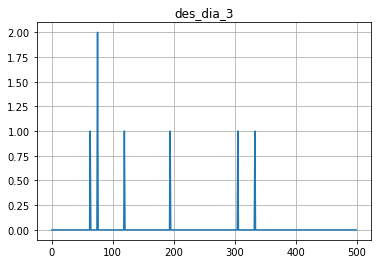

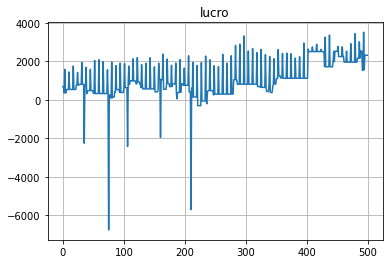

In [83]:
for col in df_results.columns:
    plt.figure()
    plt.title(col)
    df_results[col].plot()
    plt.grid()
    print(df_results[col].describe())
    print('\n')

In [84]:
df_results['data'] = date_list

In [85]:
df_results.drop(columns='lucro').to_csv('trilha_final3.csv')

In [86]:
df_results

,qtd_D,qtd_G,qtd_dia,n_L1,n_L2,n_L3,n_Geradores,custo_dia,renda_dia,des_dia_1,des_dia_2,des_dia_3,lucro,data
0,2,0,2,3,2,1,33,1125.0,1810,0,0,0,685.0,2017-06-01
1,2,0,1,3,2,1,33,1125.0,1810,1,0,0,685.0,2017-06-02
2,2,1,1,3,2,1,33,1125.0,1483,0,0,0,358.0,2017-06-03
3,2,1,0,3,2,1,33,0.0,1584,0,0,0,1584.0,2017-06-04
4,3,0,2,3,2,1,33,1125.0,1483,2,0,0,358.0,2017-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6,49,2,4,2,0,59,1000.0,3313,1,2,0,2313.0,2018-10-09
496,6,46,1,4,2,0,59,1000.0,3313,2,2,0,2313.0,2018-10-10
497,6,48,4,4,2,0,59,1000.0,3313,2,0,0,2313.0,2018-10-11
498,6,54,8,4,2,0,59,1000.0,3313,1,1,0,2313.0,2018-10-12
